In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_json
from src.similarity import fractionate,  extract_operator_patts # get_rcmcs_smarts_patt,
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display, SVG
from itertools import chain
from collections import Counter
from src.utils import construct_sparse_adj_mat
from src.cheminfo import draw_molecule, draw_reaction
from omegaconf import OmegaConf
from pathlib import Path
filepaths = OmegaConf.load("../configs/filepaths/base.yaml")

In [2]:
def sort_pair_idx(n, i, j, i2id, krs):
    ri = i2id[i[n]]
    rj = i2id[j[n]]
    smartsi = krs[ri]['smarts']
    smartsj = krs[rj]['smarts']
    return len(smartsi) + len(smartsj)

In [3]:
krs = load_json(Path(filepaths.data) / "sprhea/v3_folded_pt_ns.json")

In [4]:
# S = np.load(filepaths['sim_mats'] / "sprhea_v3_folded_pt_ns_rcmcs.npy")
# i2id = load_json("/home/stef/hiec/artifacts/sim_mats/sprhea_v3_folded_pt_ns_rcmcs_sim_i_to_id.json")
# i2id = {int(k) : v for k, v in i2id.items()}
# krs = load_json(filepaths['data'] / "sprhea/v3_folded_pt_ns.json")
# krs = {int(k): v for k,v in krs.items()}
# rules = pd.read_csv(
#             filepath_or_buffer=filepaths['data'] / 'minimal1224_all_uniprot.tsv',
#             sep='\t'
#         ).set_index('Name')
# rules.head()

In [5]:
# n = srt_ns[x]
# ri = i2id[i[n]]
# rj = i2id[j[n]]
# smartsi = krs[ri]['smarts']
# smartsj = krs[rj]['smarts']
# x += 1
# AllChem.ReactionFromSmarts(smartsi, useSmiles=True)

In [6]:
# AllChem.ReactionFromSmarts(smartsj, useSmiles=True)

In [7]:
# print(ri, rj)

In [8]:
# ub = 0.6
# ep = 1e-4
# i, j =np.where(abs(S - ub) < ep)
# print(S[i[0], j[0]])
# ns = [x for x in range(len(i))]
# srt_ns = sorted(ns, key=lambda x : sort_pair_idx(x, i, j, i2id, krs))
# x = 10

In [9]:
# n = srt_ns[x]
# ri = i2id[i[n]]
# rj = i2id[j[n]]
# smartsi = krs[ri]['smarts']
# smartsj = krs[rj]['smarts']
# x += 1
# AllChem.ReactionFromSmarts(smartsi, useSmiles=True)

In [10]:
AllChem.ReactionFromSmarts(smartsj, useSmiles=True)

NameError: name 'smartsj' is not defined

In [ ]:
# ub = 0.4
# ep = 1e-4
# i, j =np.where(abs(S - ub) < ep)
# print(S[i[0], j[0]])
# ns = [x for x in range(len(i))]
# srt_ns = sorted(ns, key=lambda x : sort_pair_idx(x, i, j, i2id, krs))
# x = 10

0.4


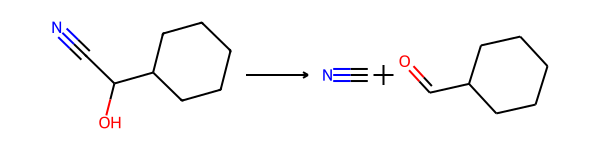

In [ ]:
# n = srt_ns[x]
# ri = i2id[i[n]]
# rj = i2id[j[n]]
# smartsi = krs[ri]['smarts']
# smartsj = krs[rj]['smarts']
# x += 1
# AllChem.ReactionFromSmarts(smartsi, useSmiles=True)

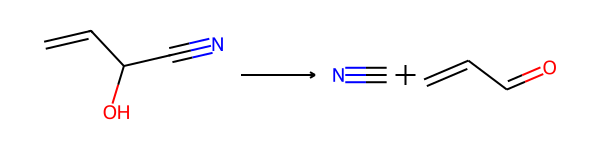

In [ ]:
# AllChem.ReactionFromSmarts(smartsj, useSmiles=True)

In [ ]:
# print(ri, rj)

6717 8481


In [ ]:
def get_mol_rc_patt(rid, krs, rules, reverse):
    smarts = krs[rid]['smarts']
    rcs = krs[rid]['rcs']
    this_rules = krs[rid]['min_rules']
    
    if reverse:
        smarts = ">>".join(smarts.split(">>")[::-1])
        rcs = rcs[::-1]
        rule = this_rules[1]
    else:
        rule = this_rules[0]

    template = rules.loc[rule, "SMARTS"]
    patts = [extract_operator_patts(template, 0), extract_operator_patts(template, 1)]
    smiles = [elt.split(".") for elt in smarts.split(">>")]
    mols = [[Chem.MolFromSmiles(smi) for smi in side] for side in smiles]
    return mols, rcs, patts

mols, rcs, patts = get_mol_rc_patt(4324, krs, rules, reverse=False)
print(mols)
print(rcs)
print(patts)

[[<rdkit.Chem.rdchem.Mol object at 0x7f8b9c58b610>], [<rdkit.Chem.rdchem.Mol object at 0x7f8b9c58b8b0>, <rdkit.Chem.rdchem.Mol object at 0x7f8b9c58b990>]]
[[[4, 6, 8]], [[1], [1, 0]]]
[['[#6]-[#6]-[#8]'], ['[#6]', '[#6]=[#8]']]


In [ ]:
rid_pairs = [
    [4324, 2535],
    [3299, 18915],
    [6717, 8481],
]

to_reverse = [elt for elt in chain(*rid_pairs) if elt != 4324]

rxn_info = {}
for pair in rid_pairs:
    for rid in pair:
        mols, rcs, patts = get_mol_rc_patt(rid, krs, rules, rid in to_reverse)
        rxn_info[rid] = {
            'mols': mols,
            'rcs': rcs,
            'patts': patts
        }

mol_svgs = {}
for ri, rj in rid_pairs:
    mol_svgs[ri] = [[], []]
    mol_svgs[rj] = [[], []]
    for side in range(2):
        for x in range(len(rxn_info[ri]['mols'][side])):
            mol_rci = (rxn_info[ri]['mols'][side][x], rxn_info[ri]['rcs'][side][x])
            mol_rcj = (rxn_info[rj]['mols'][side][x], rxn_info[rj]['rcs'][side][x])
            patt = rxn_info[ri]['patts'][side][x]
            rss = get_rcmcs_smarts_patt(mol_rci, mol_rcj, patt)

            for y, mol in zip([ri, rj], [mol_rci[0], mol_rcj[0]]) :
                hidxs = mol.GetSubstructMatch(Chem.MolFromSmarts(rss))
                for atom in mol.GetAtoms():
                    atom.SetIsotope(0)
                svg = draw_mol_svg(mol, hilite_atoms=hidxs)
                mol_svgs[y][side].append(svg)

for i, (k, v) in enumerate(mol_svgs.items()):
    rxn = draw_rxn_from_mol_svg(v)
    rxn.save(f"../artifacts/imgs/rcmcs_demo_rhea_rxn_{k}_pair_{i // 2}.svg")


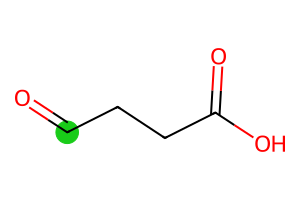

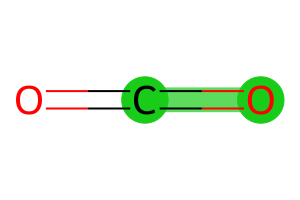

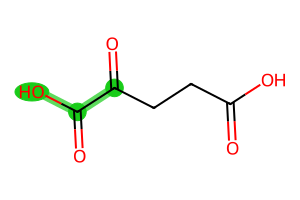

In [ ]:

smarts = krs['512']['smarts']
lhs, rhs = [elt.split(".") for elt in smarts.split(">>")]
size = (300, 200)
ha = [
    (1,),
    (0, 1),
    (7, 9, 5),
]
hcolor = (0.1, 0.8, 0.1, 0.7)
mol_names = [
    "akg_semialdehyde",
    "co2",
    "akg",
]


for i, elt in enumerate(lhs + rhs):
    svg = draw_molecule(elt, size=size, highlight_atoms=ha[i], draw_options={'setHighlightColour': hcolor})
    display(SVG(svg))
    with open(Path(filepaths.artifacts) /  f"imgs/{mol_names[i]}.svg", 'w') as f:
        f.write(svg)
    

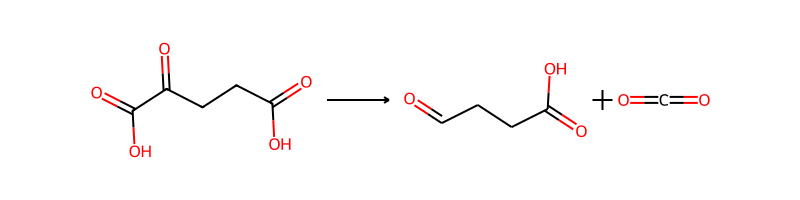

In [ ]:
rev_smarts = ">>".join(smarts.split(">>")[::-1])
svg = draw_reaction(rev_smarts)
with open(Path(filepaths.artifacts) /  f"imgs/akg_decarboxylation.svg", 'w') as f:
    f.write(svg)
display(SVG(svg))

In [11]:
adj, idx_sample, idx_feature = construct_sparse_adj_mat(Path(filepaths.data) / "sprhea" / "v3_folded_pt_ns.csv")

Constructing v3_folded_pt_ns sparse adjacency matrix


In [12]:
nrows, ncols = adj.shape
print(adj.sum() / (nrows * ncols))

0.00030975533299187506


In [13]:
r_per_p = np.array(adj.sum(axis=1)).ravel()
p_per_r = np.array(adj.sum(axis=0)).ravel()
n_pairs = adj.nnz
nprot, nr = adj.shape
mean_r_per_p, std_r_per_p = r_per_p.mean(), r_per_p.std()
mean_p_per_r, std_p_per_r = p_per_r.mean(), p_per_r.std()

In [14]:
print(f"{nprot} proteins, {nr} reactions, {n_pairs} pairs")
print(f"Reactions per protein: {mean_r_per_p} \pm {std_r_per_p}")
print(f"Proteins per reaction: {mean_p_per_r} \pm {std_p_per_r}")

24523 proteins, 6460 reactions, 49071 pairs
Reactions per protein: 2.001019451127513 \pm 2.630107259682759
Proteins per reaction: 7.596130030959753 \pm 50.42952244716726


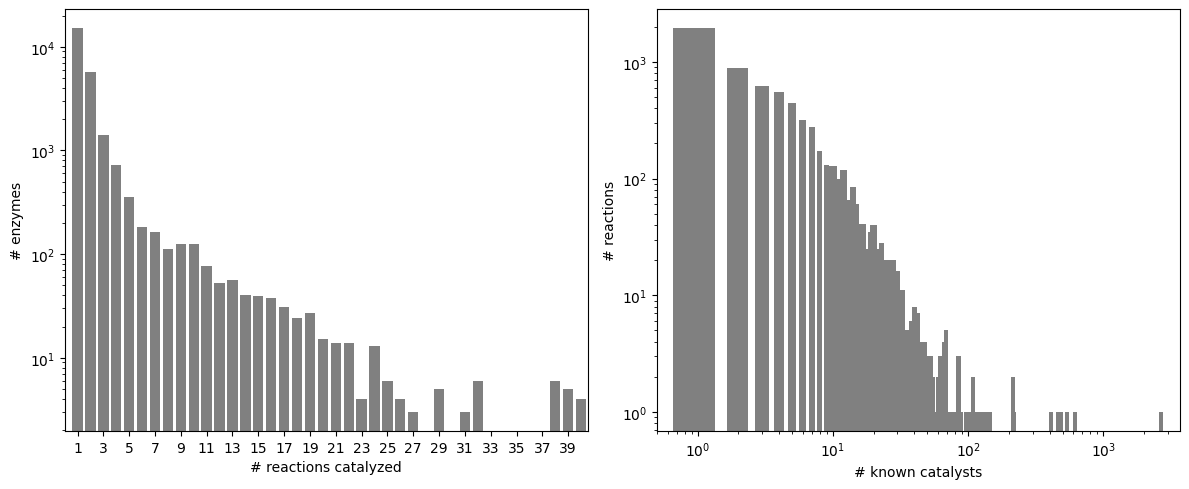

Proteins per reaction: 7.6 $\pm$ 50.4
Reactions per protein: 2.0 $\pm$ 2.6


In [61]:
color = 'gray'
widths = [((elt // 10) + 1) * 0.7 for elt in Counter(p_per_r).keys()]
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].bar(Counter(r_per_p).keys(), Counter(r_per_p).values(), color=color)
ax[1].bar(Counter(p_per_r).keys(), Counter(p_per_r).values(), width=widths, color=color)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(0, r_per_p.max() + 0.5)
ax[1].set_xlim(0.5, p_per_r.max() + 1000)
ax[0].set_xticks(range(1, r_per_p.max() + 1, 2))
ax[0].set_xlabel("# reactions catalyzed")
ax[0].set_ylabel("# enzymes")
ax[1].set_xlabel("# known catalysts")
ax[1].set_ylabel("# reactions")
plt.tight_layout()
plt.savefig(Path(filepaths.artifacts) / "figures/methods/adj_mat_row_col_sums.svg")
plt.show()

print(f"Proteins per reaction: {mean_p_per_r:.1f} " + r"$\pm$" + f" {std_p_per_r:.1f}")
print(f"Reactions per protein: {mean_r_per_p:.1f} " + r"$\pm$" + f" {std_r_per_p:.1f}")

In [53]:
103 // 10

10

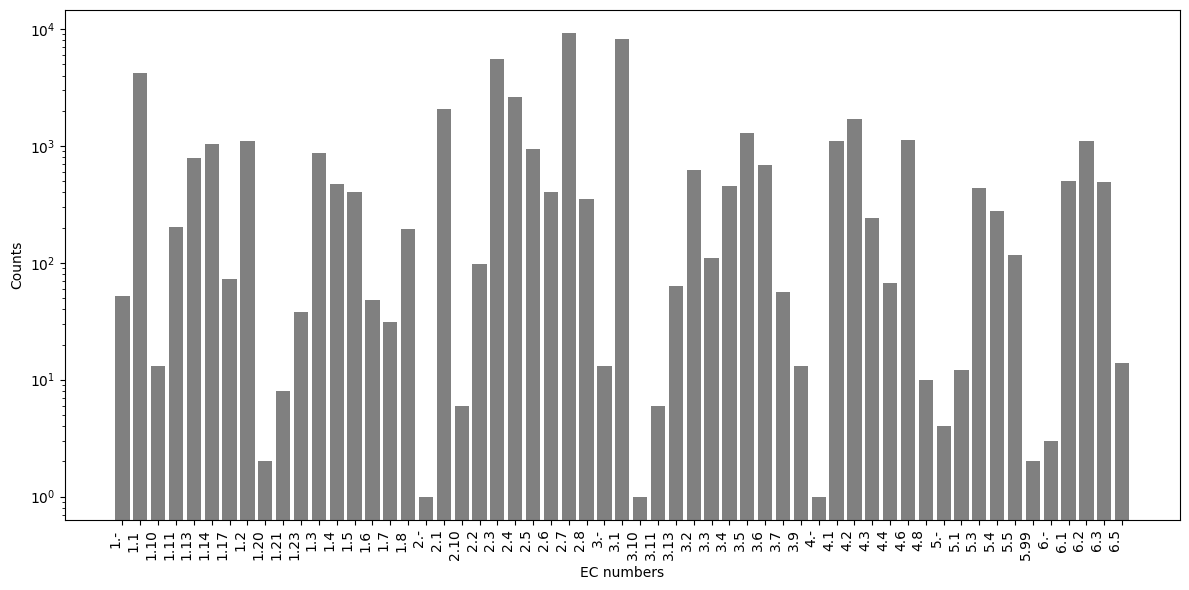

In [ ]:
n_digits = 2
ecs = [enz['ec'] for rxn in krs.values() for enz in rxn['enzymes'] ]
ecs = [".".join(elt.split(".")[:n_digits]) for elt in ecs if elt]
ec_counts = Counter(ecs)
sorted_ec_counts = dict(sorted(ec_counts.items()))

keys = list(sorted_ec_counts.keys())
values = list(sorted_ec_counts.values())

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(keys, values, color='gray')

ax.set_xlabel('EC numbers')
ax.set_ylabel('Counts')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys, ha='right', rotation=90)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(Path(filepaths.artifacts) / "figures/methods/ec_counts.svg")
plt.show()

In [ ]:
import svgutils.compose as sc
import svgutils.transform as st

def draw_mol_svg(mol, hilite_atoms=[], hcolor=(0.7, 0.9, 0.6), unscaled_width=200, height=200, scl_fcn=np.log10, width_offset=25):
    hcolor = {idx: hcolor for idx in hilite_atoms}
    nb = mol.GetNumAtoms()
    width = int(scl_fcn(nb) * unscaled_width) + width_offset
    d2d = Draw.MolDraw2DSVG(width, height)
    d2d.DrawMolecule(mol, highlightAtoms=hilite_atoms, highlightAtomColors=hcolor)
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()
    return svg

def rxn_from_smarts(smarts, reverse):
    if reverse:
        smiles = [elt.split(".") for elt in smarts.split(">>")[::-1]]
    else:
        smiles = [elt.split(".") for elt in smarts.split(">>")[::-1]]
    mol_svg = [[], []]
    for side in range(2):
        for smi in smiles[side]:
            mol = Chem.MolFromSmiles(smi)
            mol_svg[side].append(draw_mol_svg(mol))
    print([len(elt) for elt in mol_svg])

    return draw_rxn_from_mol_svg(mol_svg)

def draw_rxn_from_mol_svg(mol_svgs, plus_path="../artifacts/imgs/plus.svg", arrow_path="../artifacts/imgs/arrow.svg"):
    last_elt = lambda L : L[len(L) - 1]
    max_height = 0
    elements = []
    movex = [0]
    for side in range(2):
        for i, ms in enumerate(mol_svgs[side]):
            sfig = st.fromstring(ms)
            width, height = int(sfig.width.strip('px')), int(sfig.height.strip('px'))
            elt = sfig.getroot()
            elements.append(elt)
            movex.append(last_elt(movex) + width)

            if i < len(mol_svgs[side]) - 1:
                plus = sc.SVG(plus_path)
                elements.append(plus)
                movex.append(last_elt(movex) + plus.width)
            
            if height > max_height:
                max_height = height 
        
        if side == 0:
            arrow = sc.SVG(arrow_path)
            elements.append(arrow)
            movex.append(last_elt(movex) + arrow.width)

    for i, elt in enumerate(elements):
        elt.moveto(movex[i], 0)

    overall_width = movex[-1]
    print(overall_width, max_height)
    rxn = sc.Figure(overall_width, max_height, *elements)
    return rxn

Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.*NC(COP(=O)(O)O)C(*)=O>>*NC(CO)C(*)=O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O
[2, 2]
1199.0 200


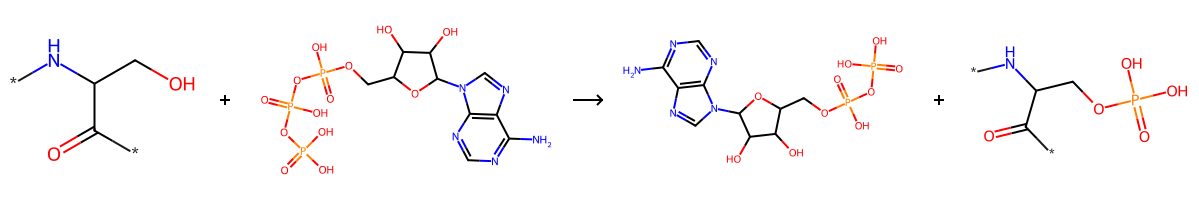

In [ ]:
smarts = krs[int(idx_feature[np.argmax(p_per_r)])]['smarts']
print(smarts)
rxn = rxn_from_smarts(smarts, True)
rxn.save("../artifacts/imgs/kinase_reaction_w_most_proteins.svg")